In [1]:
import pandas as pd
import numpy as np
import pickle
from FPMC import FPMC as FM
import dill
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

%matplotlib inline

In [16]:
fName = 'fullModel-12June.pcl'
obj = FM()
obj.load(fName)

In [17]:
obj._VIL.shape

(49689L, 128L)

In [5]:
# import products description
products    =  pd.read_csv('../data/products.csv',index_col='product_id')

In [6]:
orders = pd.read_csv('../data/orders.csv',index_col = 'order_id',
                     usecols = ['order_id','user_id','eval_set','order_number','days_since_prior_order'])

usecols = ['order_id','product_id']
items = pd.concat([pd.read_csv('../data/order_products__train.csv',usecols = usecols),
                   pd.read_csv('../data/order_products__prior.csv',usecols = usecols)])

In [7]:
def f1Score(y_true, y_pred):
    fullSet      = np.unique(np.hstack((y_pred,y_true)))
    intersection = np.intersect1d(y_true,y_pred).size
    precession   = intersection/float(y_pred.shape[0])
    recall       = intersection/float(y_true.shape[0])
    try:
        f1 = 2*precession*recall/(precession+recall)
    except ZeroDivisionError:
        f1 = 0
    return [precession, recall, f1]

In [8]:
def testModel(tUser,verbose = False, addPrev = False):
    userOrders = orders.query('user_id == @tUser')

    testOrder = userOrders.query("eval_set != 'prior'")

    trainOrders = userOrders.query("eval_set == 'prior'")
    trainOrderIds = trainOrders.index.values

    if testOrder.eval_set.values == 'test':
        print 'Test user'
        return

    else:
        testOrderId = testOrder.index.values

    # получаем id всех предварительных заказов    

    # train the model
    if addPrev:
        prevOrderId = userOrders.query('order_number == 1').index.values
        prevBasket = items.query('order_id == @prevOrderId').product_id.values

        for newOrderId in userOrders.index.values[1:-1]:
            if verbose:
                print 'Order id is', newOrderId
            newBasket = items.query('order_id == @newOrderId').product_id.values
            obj.addOrder(tUser,newBasket,prevBasket,iterations = 1e3)
            prevBasket = newBasket
    else:
        prevOrderNumber =  testOrder.order_number.values - 1
        prevOrderId = userOrders.query('order_number == @prevOrderNumber').index.values
        prevBasket = items.query('order_id == @prevOrderId').product_id.values

    testBasket = items.query('order_id == @testOrderId').product_id.values

    ordIds = userOrders.index.values[:-1]
    
    userItems = items.query('order_id in @trainOrderIds')

    # формирование полного списка купленного 
    fullBasket = userItems.groupby('product_id').count() 
    fullBasket.rename(columns={'order_id':'quantity'},inplace=True)
    fullBasket = fullBasket.merge(products,left_index=True,right_index=True).drop(['aisle_id','department_id'],axis = 1) 
    
    # расчёт среднего размера корзины
    size = np.round(userItems.groupby('order_id').count().mean()).values
    
    for k ,v in fullBasket.iterrows():
        fullBasket.loc[k,'prob'] =  obj.getProbability(basket=prevBasket, item=k, user=tUser)
        fullBasket.loc[k,'wasOrdered'] = k in testBasket
    
    
    fullBasket.sort_values('wasOrdered',ascending=False,inplace=True)
    ##fullBasket.head(50)
    fpr, tpr, thresholds = roc_curve(fullBasket.wasOrdered,fullBasket.prob)
    plt.plot(fpr,tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
    print 'FPMC model'
    recommendation = fullBasket.sort_values('prob',ascending=False).index.values[:int(size)]
    print recommendation
    [pr, recall, f1] = f1Score(testBasket,recommendation)
    print 'Precession ', pr
    print 'Recall ', recall
    print 'f1-score ',f1
    
    print '\nMost popular model'
    recommendation = fullBasket.sort_values('quantity',ascending=False).index.values[:int(size)]
    print recommendation
    [pr, recall, f1] = f1Score(testBasket,recommendation)
    print 'Precession ', pr
    print 'Recall ', recall
    print 'f1-score ',f1
    
    return [fullBasket, pr, recall, f1]

FPMC model
[17424  1158  5020  9839 38159 40604  8239 41065]
Precession  0.125
Recall  0.0833333333333
f1-score  0.1

Most popular model
[45007 24852 13932 41065 26620 45200 18027 19048]
Precession  0.25
Recall  0.166666666667
f1-score  0.2


,quantity,product_name,prob,wasOrdered
product_id,,,,
26369,3,Organic Roma Tomato,3.311057,True
21616,2,Organic Baby Arugula,3.104290,True
5134,1,Organic Thompson Seedless Raisins,1.939765,True
45007,10,Organic Zucchini,3.086300,True
41065,5,Organic Yellow Squash,3.638081,True
651,1,Organic Salted Butter,2.741808,False
30450,2,Creamy Almond Butter,1.989325,False
35108,2,Salted Butter,3.083178,False
34819,2,Liquid Vitamin C Orange Flavor,-8.920564,False


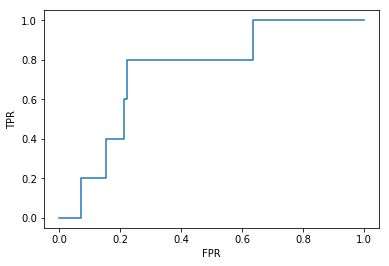

In [56]:
obj.load(fName)
[b,p,r,f1] = testModel(37)
b

In [9]:
obj.load(fName)
resFrame = testModel(1,addPrev=True,verbose = True)

Order id is 2398795


FPMC.py:207: RuntimeWarning: overflow encountered in exp
  return 1.0/(1+np.exp(-(x1-x2)))


Order id is 473747
Order id is 2254736
Order id is 431534
Order id is 3367565
Order id is 550135
Order id is 3108588
Order id is 2295261


KeyboardInterrupt: 

FPMC model
[33276 49451 19051 39877  8479  7781 22829  5322 42342 21227 34688  4957
 22825 48099]
Precession  0.0714285714286
Recall  0.0322580645161
f1-score  0.0444444444444

Most popular model
[32792 47209 24852  1559 18523 19156 12000 16589 33754 22124 47766  2002
 19051 32139]
Precession  0.214285714286
Recall  0.0967741935484
f1-score  0.133333333333


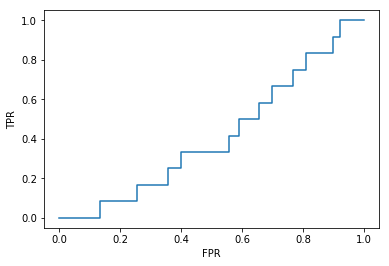

In [10]:
obj.load(fName)
[b,p,r,f1] = testModel(2)

FPMC model
[ 9116 37004 17993 47226]
Precession  0.25
Recall  0.166666666667
f1-score  0.2

Most popular model
[17993 21650 23734  9116]
Precession  0.75
Recall  0.5
f1-score  0.6


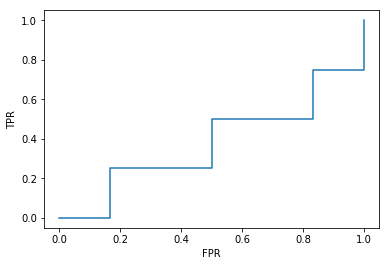

In [11]:
obj.load(fName)
[b,p,r,f1] = testModel(200222,verbose=True)

FPMC model
[26427  5612 22935 13176 22825 11933 34243]
Precession  0.142857142857
Recall  0.166666666667
f1-score  0.153846153846

Most popular model
[ 6182  5612 23165 41950 19678 13176 47209]
Precession  0.428571428571
Recall  0.5
f1-score  0.461538461538


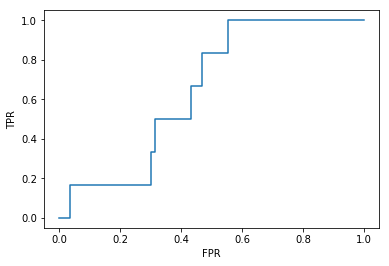

In [15]:
obj.load(fName)
[b,p,r,f1] = testModel(50, verbose=True)

In [14]:
b

,quantity,product_name,prob,wasOrdered
product_id,,,,
13029,8,Ready Pac Salad Santa Fe Caesar Bowls,-5.657667,True
29363,15,Cinnamon Cereal,0.562703,True
4137,1,Whole Grain Oat Cereal,2.423002,True
39646,5,"Red Onions, Fresh Diced",4.928536,True
24852,20,Banana,1.632764,True
9076,1,Blueberries,3.003954,True
31981,21,1% Low Fat Milk,1.873425,True
15268,6,Tai Pei Orange Chicken,0.317593,True
4094,1,Lean Gourmet Five Cheese Lasagna,-0.253001,False
